# Case study of time series - determine best investition into marketing

In [1]:
# !pip install os
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install datetime
# !pip install statsmodels
# !pip install sklearn
# !pip install warnings
# !pip install jupyter

### Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings("ignore")

## Import files

In [3]:
current_directory = os.getcwd()

# monthly
file_name_M = "data_monthly.csv"
file_path_M = os.path.join(current_directory, file_name_M)

# weekly
file_name_W = "data_weekly.csv"
file_path_W = os.path.join(current_directory, file_name_W)

In [4]:
data_monthly = pd.read_csv(file_path_M)
data_weekly = pd.read_csv(file_path_W)

## Data monthly

In [5]:
data_monthly.isna().sum()

Date            0
unemployment    0
tourists        0
gdp             0
confidence      0
dtype: int64

- All data is available

In [6]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          36 non-null     object 
 1   unemployment  36 non-null     float64
 2   tourists      36 non-null     int64  
 3   gdp           36 non-null     float64
 4   confidence    36 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.5+ KB


In [7]:
data_monthly.describe()

,unemployment,tourists,gdp,confidence
count,36.000000,3.600000e+01,36.000000,36.000000
mean,3.389950,8.795101e+05,0.781138,113.587810
std,0.726428,1.827837e+05,0.578438,3.333051
min,2.567244,5.498160e+05,0.330304,106.951748
25%,2.823319,7.513848e+05,0.492711,110.679504
50%,3.133813,9.153340e+05,0.587144,113.870893
75%,3.824735,9.873945e+05,0.700034,115.828636
max,5.290542,1.192978e+06,2.443518,119.395482


In [8]:
data_monthly["Date"] = pd.to_datetime(data_monthly["Date"], format="%d.%m.%Y")

## Data weekly

In [9]:
data_weekly.isna().sum()

Date                        0
investment_tv               0
investment_radio            0
investment_press            0
investment_banners          0
investment_online           0
stores_opened               0
economy_index               0
investment_competition      0
public_holidays             0
brand_knowledge             0
christmas_dummy             0
weather_index               0
investment_competition_1    0
investment_competition_2    0
precipitation_index         0
competitor_recognition_1    0
competitor_recognition_2    0
YearWeek                    0
sales                       0
dtype: int64

In [10]:
data_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      117 non-null    object 
 1   investment_tv             117 non-null    float64
 2   investment_radio          117 non-null    float64
 3   investment_press          117 non-null    float64
 4   investment_banners        117 non-null    float64
 5   investment_online         117 non-null    float64
 6   stores_opened             117 non-null    int64  
 7   economy_index             117 non-null    float64
 8   investment_competition    117 non-null    float64
 9   public_holidays           117 non-null    int64  
 10  brand_knowledge           117 non-null    float64
 11  christmas_dummy           117 non-null    int64  
 12  weather_index             117 non-null    float64
 13  investment_competition_1  117 non-null    float64
 14  investment

In [11]:
data_weekly["Date"] = pd.to_datetime(data_weekly["Date"], format="%d.%m.%Y")

## Merge data

In [12]:
print('Min date for month data' + str(data_monthly["Date"].min()))
print('Max date for month data' + str(data_monthly["Date"].max()))
print('-------------')
print('Min date for weekly data' + str(data_weekly["Date"].min()))
print('Max date for weekly data' + str(data_weekly["Date"].max()))

Min date for month data2020-01-01 00:00:00
Max date for month data2022-12-01 00:00:00
-------------
Min date for weekly data2020-10-01 00:00:00
Max date for weekly data2022-12-22 00:00:00


In [13]:
# instead of this let's interpolate the missing data between start of months

# data_monthly["yyyymm"] = data_monthly["Date"].dt.strftime("%Y%m")
# data_weekly["yyyymm"] = data_weekly["Date"].dt.strftime("%Y%m")
# data_monthly = data_monthly.drop("Date", axis=1,inplace=False).copy()

Interpolation is implemented after merging monthly and weekly data to fill missing values.

In [14]:
to_interpolate = data_monthly.columns.tolist()[1:]
to_interpolate

['unemployment', 'tourists', 'gdp', 'confidence']

In [15]:
# Ensure 'Date' column is in datetime format
data_weekly['Date'] = pd.to_datetime(data_weekly['Date'])
data_monthly['Date'] = pd.to_datetime(data_monthly['Date'])

# Merge the dataframes
data_sales = pd.merge(data_weekly, data_monthly, on='Date', how='outer', suffixes=('_weekly', '_monthly'))

# Sort by date
data_sales = data_sales.sort_values(by='Date').reset_index(drop=True)

# Interpolate missing values
data_sales[to_interpolate] = data_sales[to_interpolate].interpolate()
data_sales = data_sales.drop(['YearWeek'], axis=1)
data_sales.dropna(inplace=True)
data_sales.columns

Index(['Date', 'investment_tv', 'investment_radio', 'investment_press',
       'investment_banners', 'investment_online', 'stores_opened',
       'economy_index', 'investment_competition', 'public_holidays',
       'brand_knowledge', 'christmas_dummy', 'weather_index',
       'investment_competition_1', 'investment_competition_2',
       'precipitation_index', 'competitor_recognition_1',
       'competitor_recognition_2', 'sales', 'unemployment', 'tourists', 'gdp',
       'confidence'],
      dtype='object')

In [16]:
data_sales.info()
print(data_sales["Date"].min())
print(data_sales["Date"].max())

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 9 to 147
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      117 non-null    datetime64[ns]
 1   investment_tv             117 non-null    float64       
 2   investment_radio          117 non-null    float64       
 3   investment_press          117 non-null    float64       
 4   investment_banners        117 non-null    float64       
 5   investment_online         117 non-null    float64       
 6   stores_opened             117 non-null    float64       
 7   economy_index             117 non-null    float64       
 8   investment_competition    117 non-null    float64       
 9   public_holidays           117 non-null    float64       
 10  brand_knowledge           117 non-null    float64       
 11  christmas_dummy           117 non-null    float64       
 12  weather_index             1

# Few visualizations to understand data

In [17]:
# set index as 'Date'
data_sales
data_sales.set_index('Date', inplace=True)
index_back_up = data_sales.index

In [18]:
data_sales

,investment_tv,investment_radio,investment_press,investment_banners,investment_online,stores_opened,economy_index,investment_competition,public_holidays,brand_knowledge,...,investment_competition_1,investment_competition_2,precipitation_index,competitor_recognition_1,competitor_recognition_2,sales,unemployment,tourists,gdp,confidence
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,9.813096e+05,0.0,236646.24270,0.0000,8.712487e+05,186.0,22777.0,6.481700e+04,0.0,0.724231,...,4.469290e+06,1.646746e+07,29.957143,0.428392,0.439821,28225189.15,3.601064,926941.0,0.635931,114.031803
2020-10-08,1.204436e+06,0.0,492336.78720,0.0000,7.809964e+05,186.0,22905.3,2.903400e+05,0.0,0.810316,...,3.424972e+06,9.855486e+06,7.314286,0.396890,0.511645,33173110.86,3.580852,878492.6,0.635931,114.353624
2020-10-15,1.321570e+06,0.0,291885.33780,0.0000,9.321739e+05,186.0,23328.8,8.249410e+05,0.0,0.778179,...,1.502713e+07,1.812631e+07,9.500000,0.440410,0.394800,30504393.42,3.560639,830044.2,0.635931,114.675445
2020-10-22,2.155215e+05,0.0,110500.83200,0.0000,6.830815e+05,186.0,23485.3,5.912910e+05,1.0,0.804275,...,1.147109e+07,1.579170e+07,30.485714,0.404397,0.413794,30335675.45,3.540426,781595.8,0.635931,114.997266
2020-10-29,9.799192e+04,0.0,58135.35929,175435.8015,5.398485e+05,186.0,23557.1,5.548889e+05,0.0,0.817915,...,1.876094e+07,2.324122e+07,19.728571,0.500315,0.452294,25670890.36,3.520213,733147.4,0.635931,115.319086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,0.000000e+00,0.0,0.00000,26600.5635,2.018774e+06,142.0,28175.0,1.746902e+07,0.0,0.709503,...,8.383346e+06,2.238505e+07,19.100000,0.552689,0.471849,23974410.26,2.813067,841172.8,0.330304,109.354676
2022-12-01,0.000000e+00,0.0,0.00000,0.0000,9.954599e+05,142.0,28109.8,1.213155e+07,0.0,0.778967,...,3.788888e+06,2.804611e+07,11.242857,0.501246,0.500979,20884279.92,2.868371,862462.0,0.330304,109.955408
2022-12-08,0.000000e+00,0.0,0.00000,0.0000,1.652220e+06,142.0,28290.7,2.062479e+07,0.0,0.721600,...,5.688530e+06,2.757024e+07,13.071429,0.493944,0.444787,21475590.81,2.868371,862462.0,0.330304,109.955408


In [19]:
index_back_up = data_sales.index

In [20]:
# define function to compare 2 values on the same graph
def plot_timeseries(axes, x, y, color, xlabel, ylabel):
  """
  Plot a time series on the provided axes.
  
  Args:
      axes (matplotlib.axes.Axes): The axes to plot the time series on.
      x (numpy.ndarray): The x-values (e.g. time) to plot.
      y (numpy.ndarray): The y-values (e.g. measurements) to plot.
      color (str): The color to use for the line plot.
      xlabel (str): The label for the x-axis.
      ylabel (str): The label for the y-axis.
  """
  axes.plot(x, y, color=color)
  axes.set_xlabel(xlabel)
  axes.set_ylabel(ylabel, color=color)
  axes.tick_params('y', colors=color, labelsize=9)
  axes.tick_params(axis='x', labelsize=8)

In [21]:
def subplot_timeseries(data=data_sales, reference = ["sales"], columns = data_sales.columns, f_size=(12,16), ref=True):
    """
    Plots a time series graph with multiple subplots, where each subplot displays a comparison between a reference time series (e.g. sales) and another time series.
    
    Args:
        data (pandas.DataFrame): The input data to be plotted.
        reference (list): A list containing the name of the reference time series to be plotted.
        columns (list): A list of column names from the input data to be plotted.
        f_size (tuple): The figure size for the subplots.
        ref (bool): If True, the reference time series will be plotted in each subplot. If False, the reference time series will be omitted.
    
    Returns:
        None
    """
    # columns = data.columns
    # rows and columns for subplots
    if (ref==False):
        num_cols = len(columns) - 1
    else:
        num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2  # Ensures proper layout

    # subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=f_size)
    axes = axes.flatten()

    # Plot each graph comparison in a separate subplot
    for i, col in enumerate(columns):
        if ((col == reference[0]) & (ref==False)):
            continue
        ax = axes[i]
        plot_timeseries(ax, data.index, data[reference],
                        "blue", "Time", reference[0])
        ax2 = ax.twinx()
        plot_timeseries(ax2, data.index, data[col],
                        "red", "Time", '')
        ax.set_title(col, color = "red")

    # Remove any unused subplots
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

#### For all fields

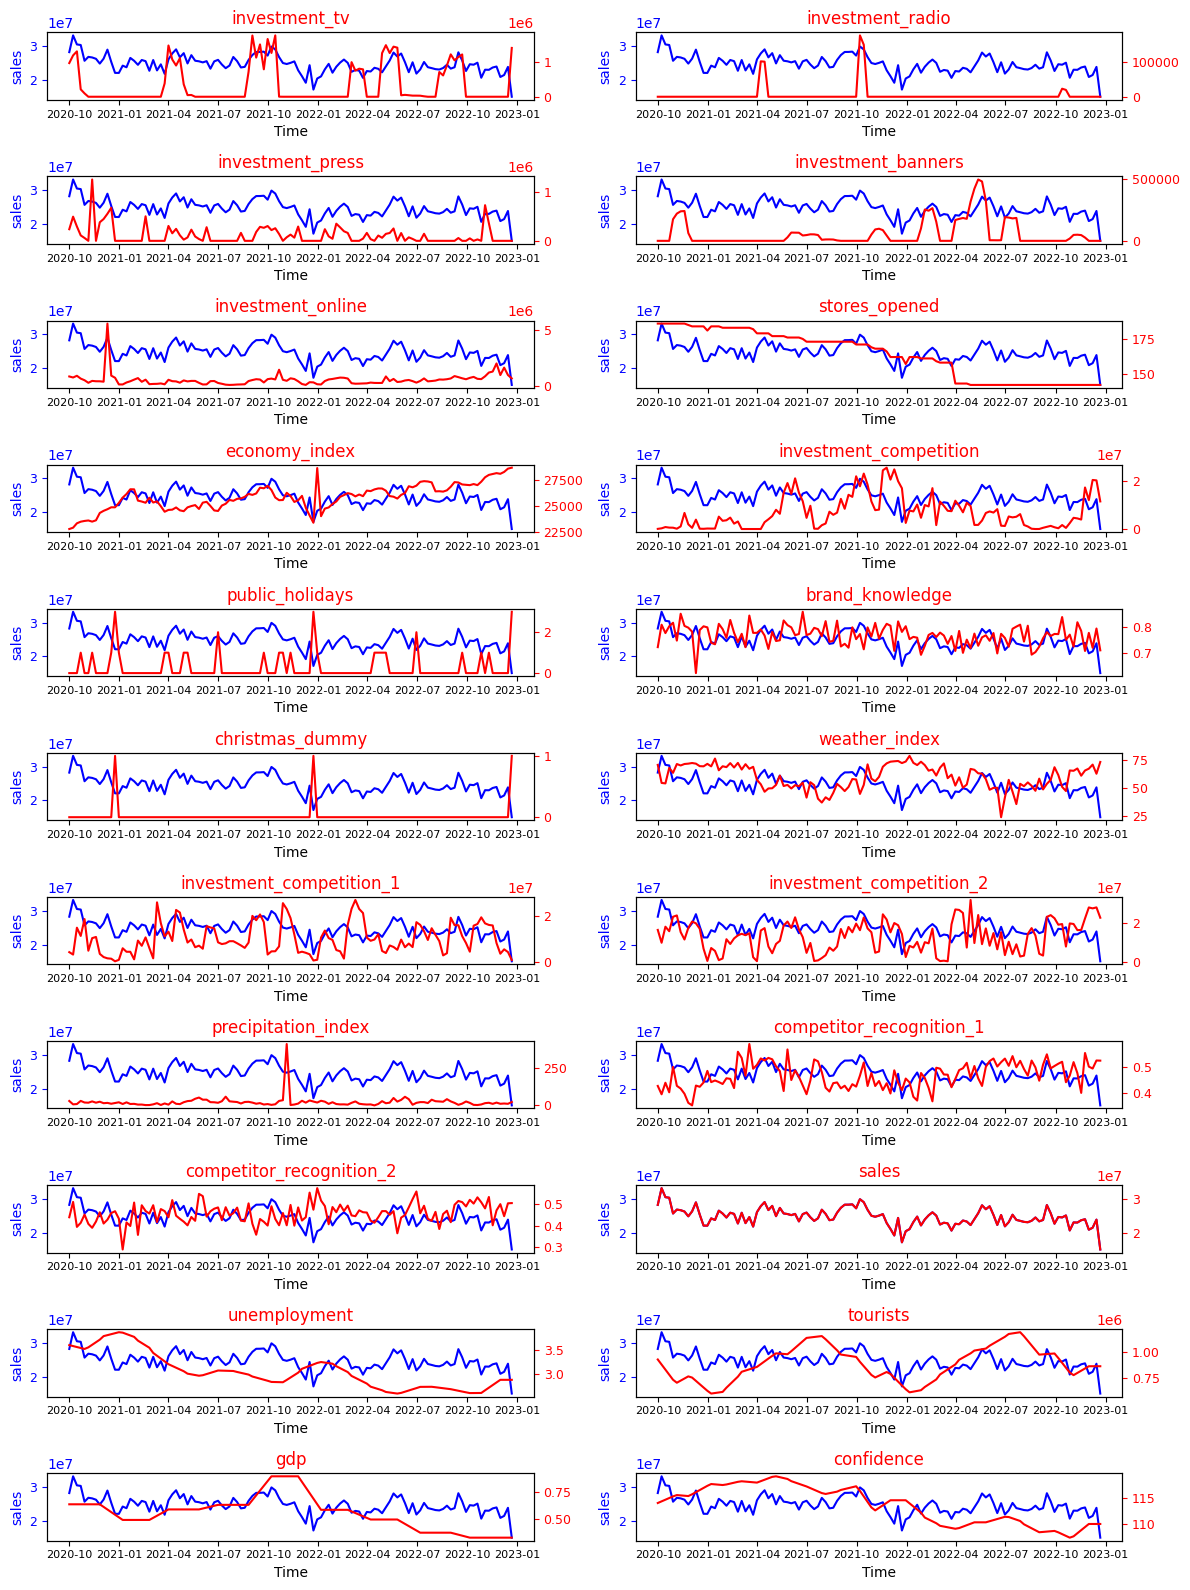

In [22]:
subplot_timeseries(data=data_sales,
                   reference = ["sales"],
                   columns = data_sales.columns,
                   f_size=(12,16),
                   ref=True)

#### Only for investments

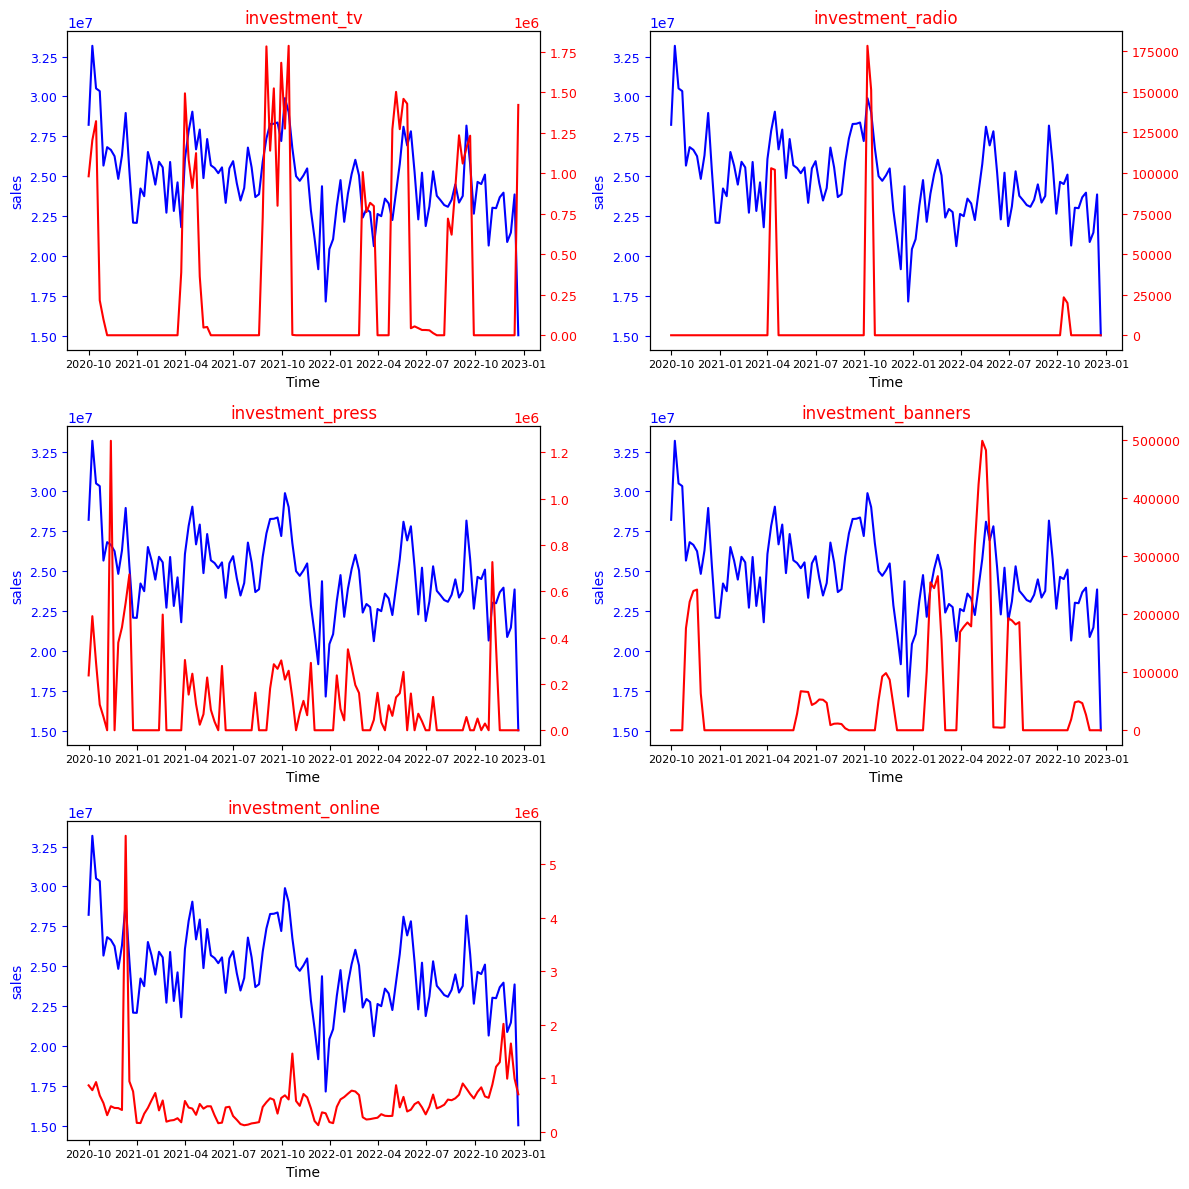

In [23]:
investments = ["investment_tv", "investment_radio", "investment_press", "investment_banners", "investment_online","sales"]
subplot_timeseries(data=data_sales,
                   reference = ["sales"],
                   columns = investments,
                   f_size=(12,12),
                   ref = False)

### Dirty graph... ehhh :(

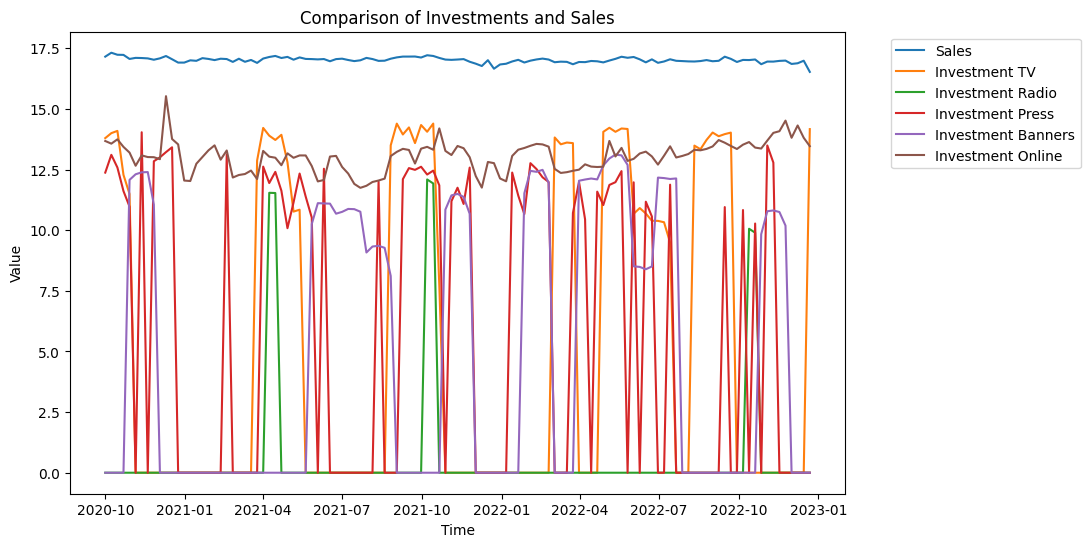

In [24]:
column_data = ["sales", "investment_tv", "investment_radio", "investment_press",
               "investment_banners", "investment_online"]
column_labels = ['Sales', 'Investment TV', 'Investment Radio', 'Investment Press',
                 'Investment Banners', 'Investment Online']

# Create the line graph
plt.figure(figsize=(10, 6))
for i, col in enumerate(column_data):
    val = pd.DataFrame(np.log(data_sales[col]))
    val = val.replace(-np.inf, 0)
    plt.plot(data_sales.index, val, label=column_labels[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Investments and Sales')
plt.show()

# Bar plot

<Figure size 1000x600 with 0 Axes>

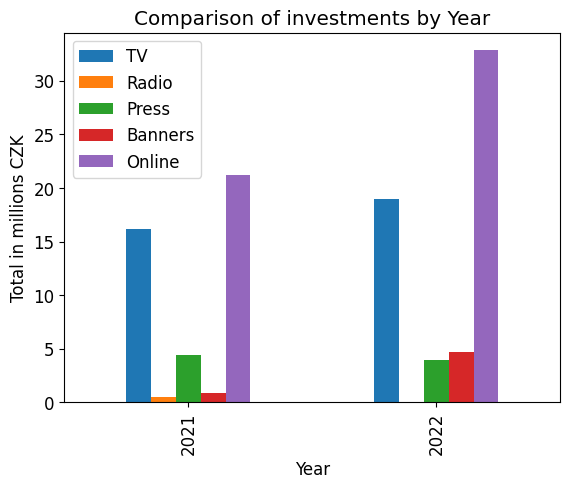

In [25]:
column_data = ["investment_tv", "investment_radio", "investment_press",
               "investment_banners", "investment_online"]
column_labels = ['TV', 'Radio', 'Press',
                 'Banners', 'Online']

# Group the data by year (assuming the date is stored in the index)
grouped_data = data_sales[column_data].groupby(data_sales.index.year).sum()
grouped_data = grouped_data/10**6 # in millions of CZK
grouped_data = grouped_data[1:3]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 12
grouped_data.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Total in millions CZK')
plt.xticks()
plt.title('Comparison of investments by Year')
plt.legend(title='',labels=column_labels)
plt.show()

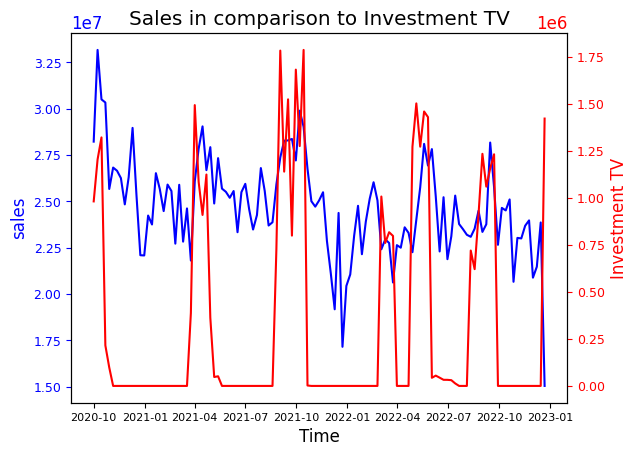

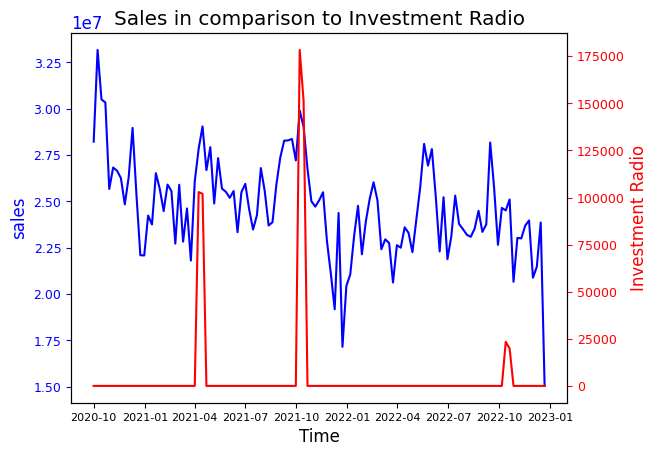

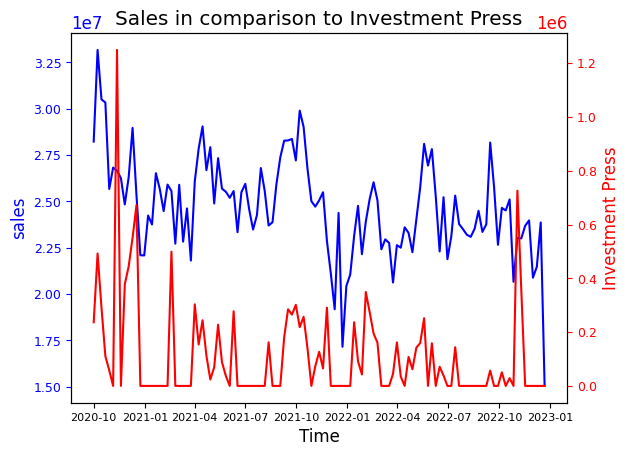

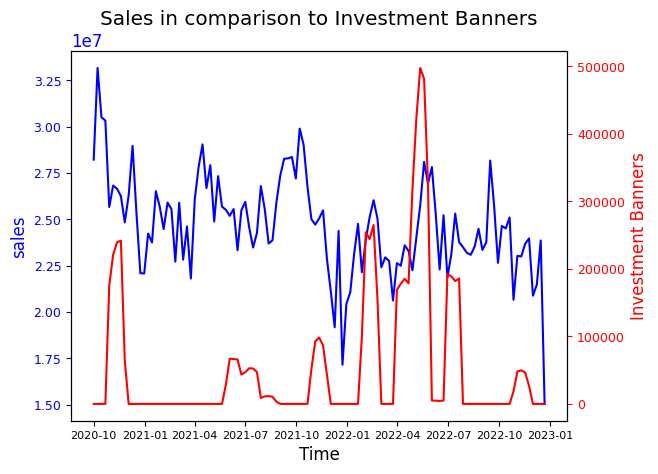

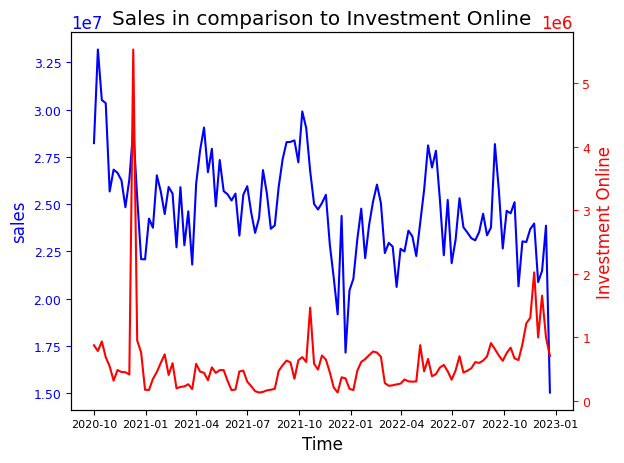

In [26]:
# Plot each slected column in a separate plot
column_data = ["investment_tv", "investment_radio", "investment_press",
               "investment_banners", "investment_online"]
column_labels = ['Investment TV', 'Investment Radio', 'Investment Press',
                 'Investment Banners', 'Investment Online']

#columns = data_sales.columns
columns = column_data
for i, col in enumerate(columns):
    fig, ax = plt.subplots()
    plot_timeseries(ax, data_sales.index, data_sales["sales"],
                    "blue", "Time", "sales")
    ax2 = ax.twinx()
    plot_timeseries(ax2, data_sales.index, data_sales[col],
                    "red", "Time", column_labels[i])
    ax.set_title(f"Sales in comparison to {column_labels[i]}")
plt.tight_layout()
plt.show()

#### Fields from monthly data
- weekly data merged with monthly data based on year and month
(day and week dropped)

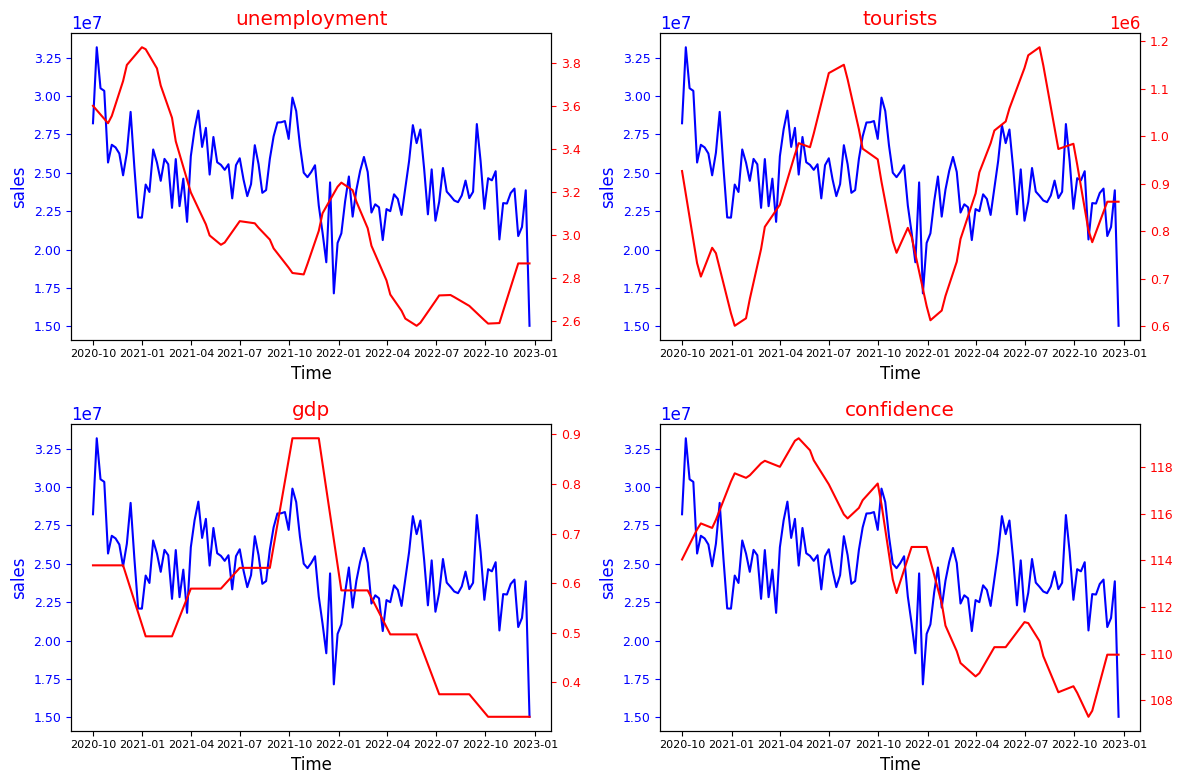

In [27]:
macro = ['unemployment', 'tourists', 'gdp', 'confidence', 'sales']
investments = ["investment_tv", "investment_radio", "investment_press", "investment_banners", "investment_online","sales"]
subplot_timeseries(data=data_sales,
                   reference = ["sales"],
                   columns = macro,
                   f_size=(12,8),
                   ref = False)

#### Fields from monthly data
- might be interesting to have a look at **unemployment** and **gdp** with monthly data from previous month

In [28]:
data_monthly["yyyymm"] = data_monthly["Date"].dt.strftime("%Y%m")
data_monthly_add = data_monthly
data_monthly_add = data_monthly_add.drop(['tourists', 'confidence'],axis=1,inplace=False).copy()

#### Correlation matrix for weekly data
- to find strong dependencies on variables
- remove variables with high correlation (remove multicolinearity)

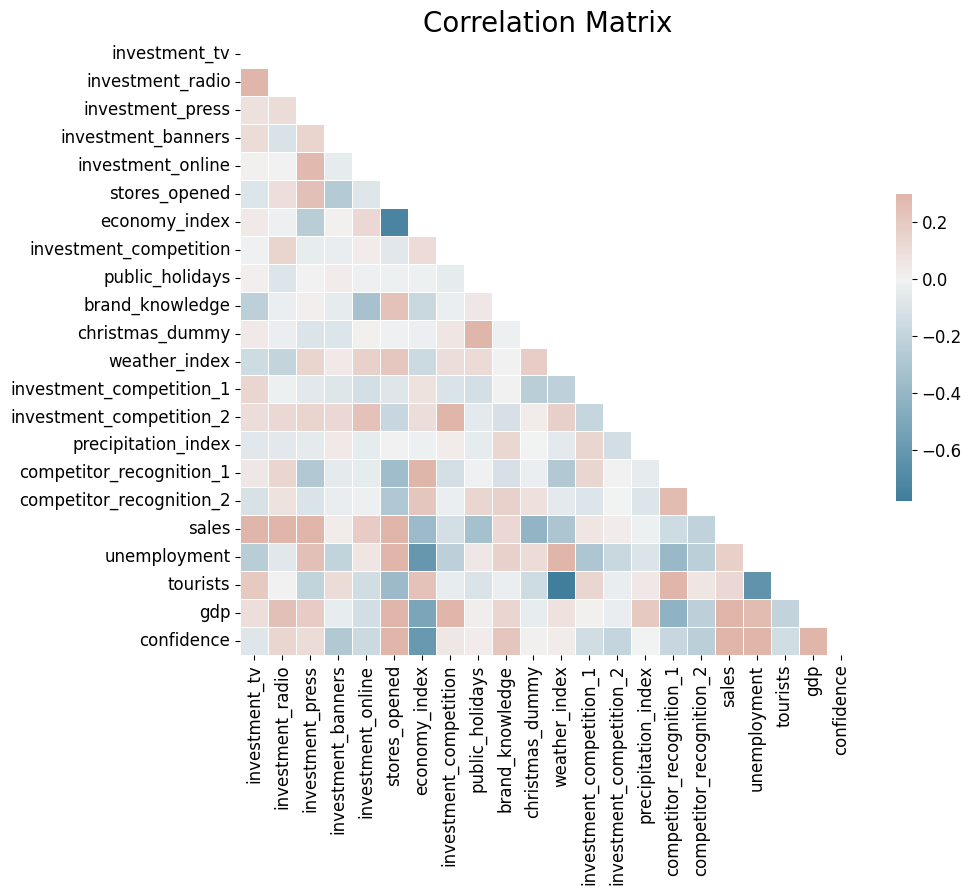

In [29]:
corr_matrix = data_sales.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title and adjust layout
plt.title('Correlation Matrix', fontsize=20)
plt.tight_layout()
plt.show()

In [30]:
corr_matrix_TF = np.abs(corr_matrix) <= 0.75

In [31]:
row_indices, col_indices = np.where(~corr_matrix_TF)

bad_var = []
# Iterate over the row and column indices
for row, col in zip(row_indices, col_indices):
    if row == col:
        continue
    bad_var.append(row)
    print(f"False value at ({row}, {col})")
bad_var = list(set(bad_var))
bad_var.sort()

False value at (5, 18)
False value at (5, 21)
False value at (11, 19)
False value at (18, 5)
False value at (19, 11)
False value at (21, 5)


In [32]:
bad_var

[5, 11, 18, 19, 21]

In [33]:
corr_matrix.iloc[bad_var,bad_var]

,stores_opened,weather_index,unemployment,tourists,confidence
stores_opened,1.000000,0.207906,0.827724,-0.378468,0.892860
weather_index,0.207906,1.000000,0.490441,-0.780312,0.029987
unemployment,0.827724,0.490441,1.000000,-0.632434,0.653383
tourists,-0.378468,-0.780312,-0.632434,1.000000,-0.142520
confidence,0.892860,0.029987,0.653383,-0.142520,1.000000


Therefore we will exclude fields **stores_opened** or **unemployment** and **confidence**.
- decision made - it is **stores_opened**


And tourists and weather index are correlated. Let's remove weather_index.

In [34]:
print(data_sales.columns)
data_sales = data_sales.drop(['stores_opened','weather_index'], axis=1,inplace=False).copy()
print('----------------------------')
print(data_sales.columns)

Index(['investment_tv', 'investment_radio', 'investment_press',
       'investment_banners', 'investment_online', 'stores_opened',
       'economy_index', 'investment_competition', 'public_holidays',
       'brand_knowledge', 'christmas_dummy', 'weather_index',
       'investment_competition_1', 'investment_competition_2',
       'precipitation_index', 'competitor_recognition_1',
       'competitor_recognition_2', 'sales', 'unemployment', 'tourists', 'gdp',
       'confidence'],
      dtype='object')
----------------------------
Index(['investment_tv', 'investment_radio', 'investment_press',
       'investment_banners', 'investment_online', 'economy_index',
       'investment_competition', 'public_holidays', 'brand_knowledge',
       'christmas_dummy', 'investment_competition_1',
       'investment_competition_2', 'precipitation_index',
       'competitor_recognition_1', 'competitor_recognition_2', 'sales',
       'unemployment', 'tourists', 'gdp', 'confidence'],
      dtype='object')


#### Stacionarity test

In [35]:
stationary = []
non_stationary = []
for col in data_sales.columns:
    # Perform the ADF test
    result = adfuller(data_sales[col])
    # Print the test results
    print(col)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    if result[1] <= 0.05:
        print(f'For col {col} reject H0 = Series is non-stationary')
        stationary.append(col)      # so stationarity is a good thing
    else: # p-value > 0.05
        print(f'This is bad. Unit root might be in {col}. Need to exclude column {col} or adjust by difference.')
        non_stationary.append(col)
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('-----------------')

investment_tv
ADF Statistic: -4.777882
p-value: 0.000060
Critical Values:
For col investment_tv reject H0 = Series is non-stationary
	1%: -3.489
	5%: -2.887
	10%: -2.580
-----------------
investment_radio
ADF Statistic: -5.483463
p-value: 0.000002
Critical Values:
For col investment_radio reject H0 = Series is non-stationary
	1%: -3.490
	5%: -2.887
	10%: -2.581
-----------------
investment_press
ADF Statistic: -8.658451
p-value: 0.000000
Critical Values:
For col investment_press reject H0 = Series is non-stationary
	1%: -3.488
	5%: -2.887
	10%: -2.580
-----------------
investment_banners
ADF Statistic: -2.122942
p-value: 0.235390
Critical Values:
This is bad. Unit root might be in investment_banners. Need to exclude column investment_banners or adjust by difference.
	1%: -3.495
	5%: -2.890
	10%: -2.582
-----------------
investment_online
ADF Statistic: -5.678014
p-value: 0.000001
Critical Values:
For col investment_online reject H0 = Series is non-stationary
	1%: -3.489
	5%: -2.887
	10

Fields in "stationary" are good fields.

In [36]:
stationary

['investment_tv',
 'investment_radio',
 'investment_press',
 'investment_online',
 'investment_competition',
 'public_holidays',
 'brand_knowledge',
 'christmas_dummy',
 'investment_competition_1',
 'investment_competition_2',
 'precipitation_index',
 'competitor_recognition_1',
 'competitor_recognition_2',
 'sales',
 'tourists']

In [37]:
# this exclude from model or create diff...
non_stationary

['investment_banners', 'economy_index', 'unemployment', 'gdp', 'confidence']

### Create differences for non-stationary variables

In [38]:
differences = pd.DataFrame()
for col in data_sales[non_stationary].columns:
    new_col = col + '_diff'
    differences[new_col] = data_sales[col].diff()

selection = ['sales', 'investment_tv', 'investment_radio', 'investment_press',
             'investment_online', 'investment_competition',]
for col in data_sales[selection].columns:
    new_col = col + '_diff'
    differences[new_col] = data_sales[col].diff()/10**6
#differences['sales_diff'] = data_sales['sales'].diff()
differences = differences.dropna()

In [39]:
differences.describe()

,investment_banners_diff,economy_index_diff,unemployment_diff,gdp_diff,confidence_diff,sales_diff,investment_tv_diff,investment_radio_diff,investment_press_diff,investment_online_diff,investment_competition_diff
count,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,1.160000e+02,116.000000,116.000000,116.000000
mean,-5.958758e-13,51.075000,-0.006316,-0.002635,-0.035141,-0.113639,0.003797,-1.196361e-19,-0.002040,-0.001445,0.099483
std,6.018389e+04,744.237823,0.035529,0.017714,0.366170,2.290480,0.421447,2.593286e-02,0.233461,0.688494,4.668457
min,-3.205563e+05,-4649.900000,-0.109398,-0.051165,-1.072736,-8.820362,-1.784592,-1.511768e-01,-1.249049,-4.583321,-15.527158
25%,-3.165271e+01,-89.625000,-0.026313,-0.002274,-0.257457,-1.561661,0.000000,0.000000e+00,-0.051450,-0.096018,-1.753714
50%,0.000000e+00,92.700000,-0.011152,0.000000,0.000000,-0.020626,0.000000,0.000000e+00,0.000000,0.005633,0.000000
75%,0.000000e+00,242.875000,0.020604,0.000000,0.225274,1.459066,0.000000,0.000000e+00,0.046521,0.098119,1.875722
max,1.877017e+05,5282.800000,0.081998,0.043589,0.600732,5.198960,1.421816,1.783457e-01,1.249049,5.118034,16.513623


In [40]:
# Check for stationarity
def test_stationarity(timeseries):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on the provided time series to check for stationarity.
    
    The ADF test is a statistical test used to determine if a time series is stationary or not. It tests the null hypothesis that the time series has a unit root (i.e., it is non-stationary) against the alternative that the time series is stationary.
    
    The function prints the results of the ADF test, including the test statistic, p-value, number of lags used, and the number of observations used. It also prints the critical values for the test at various significance levels.
    
    Parameters:
        timeseries (pandas.Series): The time series to be tested for stationarity.
    
    Returns:
        None
    """
    # Perform ADF test
    dftest = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


# Test stationarity
for i in differences.columns:
    test_stationarity(differences[i])
    print()

Results of Dickey-Fuller Test:
Test Statistic                  -3.815074
p-value                          0.002757
#Lags Used                      11.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                -9.226633e+00
p-value                        1.722148e-15
#Lags Used                     2.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -2.978221
p-value                          0.036979
#Lags Used                      13.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%) 

In [41]:
b = len(data_sales) == len(differences)
print('1. Data length is the same: ' + str(b))
if len(data_sales) != len(differences):
    data_sales = data_sales.drop(index=data_sales.index[0])
a = len(data_sales) == len(differences)
print('2. Data length is the same: ' + str(a))
if a and not b:
    data_sales = pd.concat([data_sales, differences], axis=1, join='inner')
    print('differences were merged')

1. Data length is the same: False
2. Data length is the same: True
differences were merged


In [42]:
data_sales.columns

Index(['investment_tv', 'investment_radio', 'investment_press',
       'investment_banners', 'investment_online', 'economy_index',
       'investment_competition', 'public_holidays', 'brand_knowledge',
       'christmas_dummy', 'investment_competition_1',
       'investment_competition_2', 'precipitation_index',
       'competitor_recognition_1', 'competitor_recognition_2', 'sales',
       'unemployment', 'tourists', 'gdp', 'confidence',
       'investment_banners_diff', 'economy_index_diff', 'unemployment_diff',
       'gdp_diff', 'confidence_diff', 'sales_diff', 'investment_tv_diff',
       'investment_radio_diff', 'investment_press_diff',
       'investment_online_diff', 'investment_competition_diff'],
      dtype='object')

In [43]:
non_stationary

['investment_banners', 'economy_index', 'unemployment', 'gdp', 'confidence']

In [44]:
print(data_sales.columns)
data_sales = data_sales.drop(non_stationary, axis=1,inplace=False).copy()
print('----------------------------')
print(data_sales.columns)

Index(['investment_tv', 'investment_radio', 'investment_press',
       'investment_banners', 'investment_online', 'economy_index',
       'investment_competition', 'public_holidays', 'brand_knowledge',
       'christmas_dummy', 'investment_competition_1',
       'investment_competition_2', 'precipitation_index',
       'competitor_recognition_1', 'competitor_recognition_2', 'sales',
       'unemployment', 'tourists', 'gdp', 'confidence',
       'investment_banners_diff', 'economy_index_diff', 'unemployment_diff',
       'gdp_diff', 'confidence_diff', 'sales_diff', 'investment_tv_diff',
       'investment_radio_diff', 'investment_press_diff',
       'investment_online_diff', 'investment_competition_diff'],
      dtype='object')
----------------------------
Index(['investment_tv', 'investment_radio', 'investment_press',
       'investment_online', 'investment_competition', 'public_holidays',
       'brand_knowledge', 'christmas_dummy', 'investment_competition_1',
       'investment_compe

#### Fields selection

In [45]:
data_sales.head(8)

,investment_tv,investment_radio,investment_press,investment_online,investment_competition,public_holidays,brand_knowledge,christmas_dummy,investment_competition_1,investment_competition_2,...,economy_index_diff,unemployment_diff,gdp_diff,confidence_diff,sales_diff,investment_tv_diff,investment_radio_diff,investment_press_diff,investment_online_diff,investment_competition_diff
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-08,1.204436e+06,0.0,4.923368e+05,780996.4369,2.903400e+05,0.0,0.810316,0.0,3.424972e+06,9.855486e+06,...,128.3,-0.020213,0.0,0.321821,4.947922,0.223126,0.0,0.255691,-0.090252,0.225523
2020-10-15,1.321570e+06,0.0,2.918853e+05,932173.8794,8.249410e+05,0.0,0.778179,0.0,1.502713e+07,1.812631e+07,...,423.5,-0.020213,0.0,0.321821,-2.668717,0.117134,0.0,-0.200451,0.151177,0.534601
2020-10-22,2.155215e+05,0.0,1.105008e+05,683081.4701,5.912910e+05,1.0,0.804275,0.0,1.147109e+07,1.579170e+07,...,156.5,-0.020213,0.0,0.321821,-0.168718,-1.106049,0.0,-0.181385,-0.249092,-0.233650
2020-10-29,9.799192e+04,0.0,5.813536e+04,539848.5232,5.548889e+05,0.0,0.817915,0.0,1.876094e+07,2.324122e+07,...,71.8,-0.020213,0.0,0.321821,-4.664785,-0.117530,0.0,-0.052365,-0.143233,-0.036402
2020-11-05,0.000000e+00,0.0,0.000000e+00,314046.1290,1.315732e+05,0.0,0.749231,0.0,5.086584e+06,2.393314e+07,...,45.0,0.033847,0.0,0.257457,1.154028,-0.097992,0.0,-0.058135,-0.225802,-0.423316
2020-11-12,0.000000e+00,0.0,1.249049e+06,481156.6590,1.099516e+06,1.0,0.852458,0.0,1.052178e+07,1.534342e+07,...,-109.9,0.054060,0.0,-0.064364,-0.170944,0.000000,0.0,1.249049,0.167111,0.967943
2020-11-19,0.000000e+00,0.0,0.000000e+00,449257.5600,6.765883e+06,0.0,0.805729,0.0,1.102903e+07,1.152317e+07,...,125.6,0.054060,0.0,-0.064364,-0.396669,0.000000,0.0,-1.249049,-0.031899,5.666367
2020-11-26,0.000000e+00,0.0,3.781178e+05,446691.0842,1.976699e+06,0.0,0.798979,0.0,3.723222e+06,1.747800e+07,...,710.0,0.054060,0.0,-0.064364,-1.418184,0.000000,0.0,0.378118,-0.002566,-4.789184


In [46]:
selected = [["investment_tv","investment_radio","investment_press","investment_banners",
             "investment_online", ""]]

### Data preprocessing

In [47]:
to_ln = ["tourists"]

to_milions = ["sales","investment_press","investment_radio",
              "investment_online","investment_banners_diff",
              "investment_competition","investment_competition_1",
              "investment_competition_2"]

#### Decimal Scaling:
- all money transfered to milions of Czech Crowns

In [48]:
data_sales[to_milions] = data_sales[to_milions]/10**6
data_sales[to_milions].describe()

,sales,investment_press,investment_radio,investment_online,investment_banners_diff,investment_competition,investment_competition_1,investment_competition_2
count,116.000000,116.000000,116.000000,116.000000,1.160000e+02,116.000000,116.000000,116.000000
mean,24.686045,0.108575,0.004979,0.572960,5.981805e-20,7.070515,10.323739,13.129925
std,2.622156,0.185352,0.025317,0.558210,6.018389e-02,6.916758,6.445317,7.836405
min,15.043045,0.000000,0.000000,0.126310,-3.205563e-01,0.000000,0.518196,0.298950
25%,23.109767,0.000000,0.000000,0.308720,-3.165271e-05,1.230821,4.953701,7.046164
50%,24.683277,0.000000,0.000000,0.477119,0.000000e+00,5.182373,9.217301,14.067056
75%,25.968681,0.159787,0.000000,0.683473,0.000000e+00,10.483783,15.276967,18.956050
max,33.173111,1.249049,0.178346,5.529165,1.877017e-01,25.792620,27.011960,31.914243


#### Logaritmic scaling
- natural logarithm (ln) of large numbers (can't negative and 0)

In [49]:
data_sales[to_ln] = np.log(data_sales[to_ln])
data_sales[to_ln].describe()

,tourists
count,116.000000
mean,13.677021
std,0.186865
min,13.307047
25%,13.542281
50%,13.667625
75%,13.823039
max,13.987250


### Field of sum of all competitors

In [50]:
data_sales["invest_all_compretitors"] = data_sales["investment_competition"]+\
    data_sales["investment_competition_1"]+\
    data_sales["investment_competition_2"]

In [51]:
competitors = ["invest_all_compretitors","investment_competition",
               "investment_competition_1","investment_competition_2"]
data_sales[competitors].head()

,invest_all_compretitors,investment_competition,investment_competition_1,investment_competition_2
Date,,,,
2020-10-08,13.570797,0.290340,3.424972,9.855486
2020-10-15,33.978386,0.824941,15.027135,18.126311
2020-10-22,27.854077,0.591291,11.471089,15.791698
2020-10-29,42.557045,0.554889,18.760938,23.241219
2020-11-05,29.151300,0.131573,5.086584,23.933143


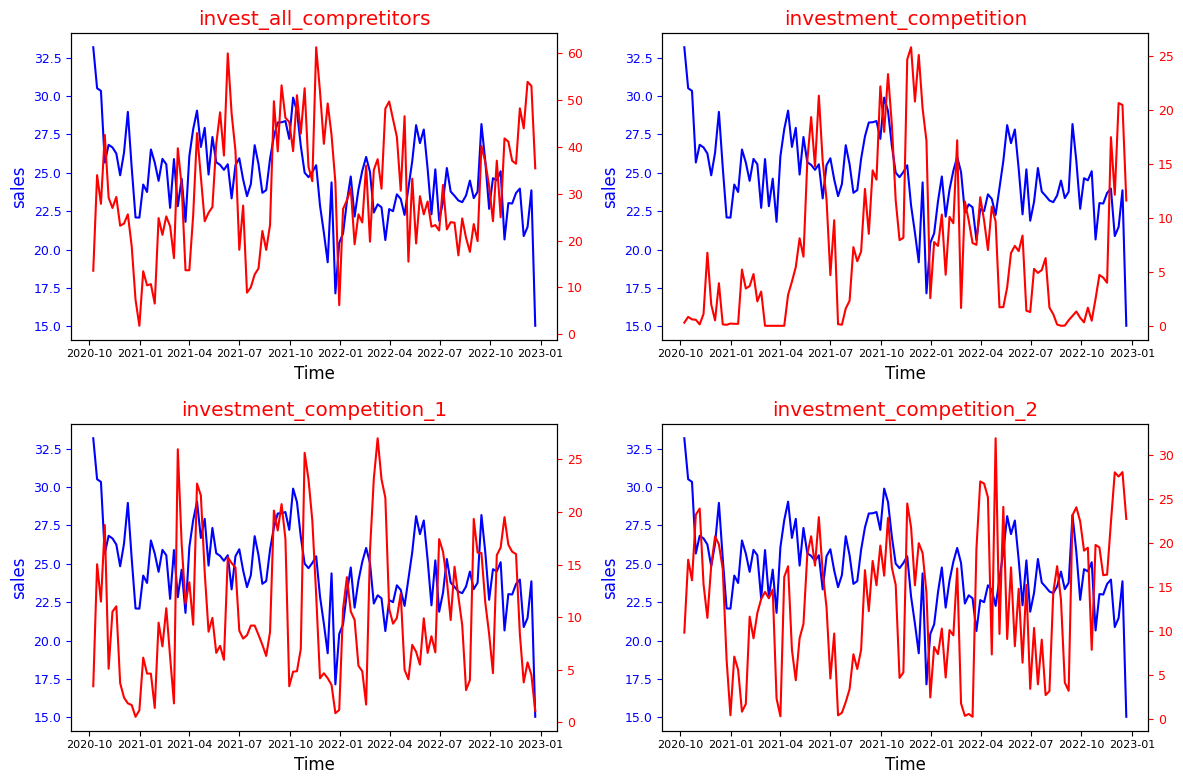

In [52]:
subplot_timeseries(data=data_sales,
                   reference = ["sales"],
                   columns = competitors,
                   f_size=(12,8),
                   ref=True)

### Finalization of data for modelling

In [53]:
data_sales[['precipitation_index']].describe()

,precipitation_index
count,116.000000
mean,22.475647
std,38.368409
min,0.514286
25%,9.739286
50%,17.692857
75%,26.667857
max,410.885714


In [54]:
data_sales.columns

Index(['investment_tv', 'investment_radio', 'investment_press',
       'investment_online', 'investment_competition', 'public_holidays',
       'brand_knowledge', 'christmas_dummy', 'investment_competition_1',
       'investment_competition_2', 'precipitation_index',
       'competitor_recognition_1', 'competitor_recognition_2', 'sales',
       'tourists', 'investment_banners_diff', 'economy_index_diff',
       'unemployment_diff', 'gdp_diff', 'confidence_diff', 'sales_diff',
       'investment_tv_diff', 'investment_radio_diff', 'investment_press_diff',
       'investment_online_diff', 'investment_competition_diff',
       'invest_all_compretitors'],
      dtype='object')

In [55]:
analysis_select = ["sales",'investment_tv','investment_radio',
                   'investment_press','investment_banners_diff','investment_online',
                   'brand_knowledge',
                   'invest_all_compretitors',
                   'precipitation_index',
                   'public_holidays','christmas_dummy',
                   'gdp_diff','unemployment_diff',
                   'economy_index_diff','tourists','confidence_diff'
                   #,"investment_competition", "investment_competition_1","investment_competition_2"
]
analysis_predictors = analysis_select[1:]

In [56]:
# sum up changes final reviews
data_analysis = data_sales[analysis_select]

In [57]:
data_analysis.head()

,sales,investment_tv,investment_radio,investment_press,investment_banners_diff,investment_online,brand_knowledge,invest_all_compretitors,precipitation_index,public_holidays,christmas_dummy,gdp_diff,unemployment_diff,economy_index_diff,tourists,confidence_diff
Date,,,,,,,,,,,,,,,,
2020-10-08,33.173111,1.204436e+06,0.0,0.492337,0.000000,0.780996,0.810316,13.570797,7.314286,0.0,0.0,0.0,-0.020213,128.3,13.685963,0.321821
2020-10-15,30.504393,1.321570e+06,0.0,0.291885,0.000000,0.932174,0.778179,33.978386,9.500000,0.0,0.0,0.0,-0.020213,423.5,13.629234,0.321821
2020-10-22,30.335675,2.155215e+05,0.0,0.110501,0.000000,0.683081,0.804275,27.854077,30.485714,1.0,0.0,0.0,-0.020213,156.5,13.569093,0.321821
2020-10-29,25.670890,9.799192e+04,0.0,0.058135,0.175436,0.539849,0.817915,42.557045,19.728571,0.0,0.0,0.0,-0.020213,71.8,13.505102,0.321821
2020-11-05,26.824919,0.000000e+00,0.0,0.000000,0.045405,0.314046,0.749231,29.151300,18.385714,0.0,0.0,0.0,0.033847,45.0,13.465824,0.257457


## Modeling

#### Basic OLS

In [58]:
if len(index_back_up) > 116:
    index_back_up = index_back_up.drop(index_back_up[0])

In [59]:
data_analysis.set_index(index_back_up, inplace=True)

In [60]:
stationary

['investment_tv',
 'investment_radio',
 'investment_press',
 'investment_online',
 'investment_competition',
 'public_holidays',
 'brand_knowledge',
 'christmas_dummy',
 'investment_competition_1',
 'investment_competition_2',
 'precipitation_index',
 'competitor_recognition_1',
 'competitor_recognition_2',
 'sales',
 'tourists']

# Linear regression model (LRM)

In [61]:
analysis_predictors

['investment_tv',
 'investment_radio',
 'investment_press',
 'investment_banners_diff',
 'investment_online',
 'brand_knowledge',
 'invest_all_compretitors',
 'precipitation_index',
 'public_holidays',
 'christmas_dummy',
 'gdp_diff',
 'unemployment_diff',
 'economy_index_diff',
 'tourists',
 'confidence_diff']

In [62]:
data_analysis = sm.add_constant(data_analysis)
results_1 = sm.OLS(data_analysis['sales'],data_analysis[['const'] + analysis_predictors]).fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     8.776
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.52e-12
Time:                        16:56:41   Log-Likelihood:                -227.20
No. Observations:                 116   AIC:                             486.4
Df Residuals:                     100   BIC:                             530.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [63]:

results_1.pvalues
results_1.params
results_1.rsquared


0.5682832612022705

In [64]:
def check_output(results=results_1, predictors=analysis_predictors,alpha=0.05):
    good_var = []
    bad_var = []
    print(f'R_squared is: {round(results.rsquared,ndigits=4)}')
    if results.rsquared < 0.3:
        print('CRUTIAL WARNING: R_squared is less than 0.3')
        print('Weak fit, garbage model')
    elif results.rsquared < 0.5:
        print('WARNING: R_squared between 0.3 and 0.5')
        print('Modest fit, explains small portion of data')
    elif results.rsquared < 0.7:
        print('R_squared is between 0.5 and 0.7')
        print('Moderate fit, reasonably good fit')
    else:
        print('R_squared is greter than 0.7')
        print('Strong fit, explains most of data')
    print('---------------------------------')
    for variable in predictors:
        p_val = round(results.pvalues[variable],ndigits=4)
        if p_val <= alpha:
            print(f"GOOD: P-value for '{variable}': {p_val}")
            good_var.append(variable)
        else:
            print(f"------> BAD: P-value for '{variable}': {p_val}")
            bad_var.append(variable)
    return good_var, bad_var

In [65]:
good_var_1, bad_var_1 = check_output(results_1,analysis_predictors,0.10)

R_squared is: 0.5683
R_squared is between 0.5 and 0.7
Moderate fit, reasonably good fit
---------------------------------
GOOD: P-value for 'investment_tv': 0.0231
GOOD: P-value for 'investment_radio': 0.006
GOOD: P-value for 'investment_press': 0.0041
------> BAD: P-value for 'investment_banners_diff': 0.3434
GOOD: P-value for 'investment_online': 0.0036
GOOD: P-value for 'brand_knowledge': 0.0024
GOOD: P-value for 'invest_all_compretitors': 0.0364
------> BAD: P-value for 'precipitation_index': 0.5094
------> BAD: P-value for 'public_holidays': 0.3341
GOOD: P-value for 'christmas_dummy': 0.006
GOOD: P-value for 'gdp_diff': 0.0026
------> BAD: P-value for 'unemployment_diff': 0.4403
------> BAD: P-value for 'economy_index_diff': 0.3765
------> BAD: P-value for 'tourists': 0.5369
------> BAD: P-value for 'confidence_diff': 0.1412


In [66]:
good_var_1

['investment_tv',
 'investment_radio',
 'investment_press',
 'investment_online',
 'brand_knowledge',
 'invest_all_compretitors',
 'christmas_dummy',
 'gdp_diff']

In [67]:
bad_var_1

['investment_banners_diff',
 'precipitation_index',
 'public_holidays',
 'unemployment_diff',
 'economy_index_diff',
 'tourists',
 'confidence_diff']

# OLS - again only with good predictors

In [68]:
results_2 = sm.OLS(data_analysis['sales'],data_analysis[['const'] + good_var_1]).fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     15.84
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           3.32e-15
Time:                        16:56:41   Log-Likelihood:                -230.60
No. Observations:                 116   AIC:                             479.2
Df Residuals:                     107   BIC:                             504.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [69]:
good_var_2, bad_var_2 = check_output(results_2,good_var_1,0.05)

R_squared is: 0.5422
R_squared is between 0.5 and 0.7
Moderate fit, reasonably good fit
---------------------------------
GOOD: P-value for 'investment_tv': 0.0028
GOOD: P-value for 'investment_radio': 0.0101
GOOD: P-value for 'investment_press': 0.0064
GOOD: P-value for 'investment_online': 0.0021
GOOD: P-value for 'brand_knowledge': 0.001
GOOD: P-value for 'invest_all_compretitors': 0.027
GOOD: P-value for 'christmas_dummy': 0.0
GOOD: P-value for 'gdp_diff': 0.0005


# OLS - differences

In [70]:
differen = ["sales_diff",'investment_tv_diff', 'investment_radio_diff', 'investment_press_diff',
            'investment_online_diff', 'investment_banners_diff',
            'brand_knowledge',
            'invest_all_compretitors',
            'precipitation_index',
            'public_holidays','christmas_dummy',
            'gdp_diff','unemployment_diff',
            'economy_index_diff','tourists','confidence_diff'
            #,"investment_competition", "investment_competition_1","investment_competition_2"
]
differen_predictors = differen[1:]

In [71]:
# differen = ['investment_tv_diff', 'investment_radio_diff', 'investment_press_diff',
#             'investment_online_diff', 'investment_banners_diff', 'brand_knowledge', 'christmas_dummy']

new_analysis = data_sales[differen]
new_analysis = sm.add_constant(new_analysis)

results_3 = sm.OLS(new_analysis['sales_diff'],new_analysis[['const'] + differen_predictors]).fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:             sales_diff   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     4.107
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           8.39e-06
Time:                        16:56:41   Log-Likelihood:                -232.39
No. Observations:                 116   AIC:                             496.8
Df Residuals:                     100   BIC:                             540.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# This is the most important part of the model analysis

In [72]:
# With all prososed fields: output to presentation
# Vojtech
good_var_3, bad_var_3 = check_output(results_3,differen_predictors,0.2)

R_squared is: 0.3812
Modest fit, explains small portion of data
---------------------------------
------> BAD: P-value for 'investment_tv_diff': 0.9627
GOOD: P-value for 'investment_radio_diff': 0.0305
GOOD: P-value for 'investment_press_diff': 0.082
GOOD: P-value for 'investment_online_diff': 0.0025
------> BAD: P-value for 'investment_banners_diff': 0.6098
GOOD: P-value for 'brand_knowledge': 0.0854
GOOD: P-value for 'invest_all_compretitors': 0.0827
------> BAD: P-value for 'precipitation_index': 0.3299
GOOD: P-value for 'public_holidays': 0.0995
GOOD: P-value for 'christmas_dummy': 0.0192
------> BAD: P-value for 'gdp_diff': 0.8842
------> BAD: P-value for 'unemployment_diff': 0.9462
------> BAD: P-value for 'economy_index_diff': 0.5921
------> BAD: P-value for 'tourists': 0.7264
------> BAD: P-value for 'confidence_diff': 0.923


# OLS - new analysis with differences - selected fields

In [73]:
results_4 = sm.OLS(new_analysis['sales_diff'],new_analysis[['const'] + good_var_3]).fit()
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:             sales_diff   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     9.067
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           9.07e-09
Time:                        16:56:41   Log-Likelihood:                -233.42
No. Observations:                 116   AIC:                             482.8
Df Residuals:                     108   BIC:                             504.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# This is the most import part of model analysis

In [74]:
# Cleared output to presentation
# Vojtech
good_var_4, bad_var_4 = check_output(results_4,good_var_3,0.05)

R_squared is: 0.3701
Modest fit, explains small portion of data
---------------------------------
GOOD: P-value for 'investment_radio_diff': 0.0214
------> BAD: P-value for 'investment_press_diff': 0.0784
GOOD: P-value for 'investment_online_diff': 0.0019
------> BAD: P-value for 'brand_knowledge': 0.0997
GOOD: P-value for 'invest_all_compretitors': 0.0426
------> BAD: P-value for 'public_holidays': 0.1251
GOOD: P-value for 'christmas_dummy': 0.0061


### Visualization into presentaion for diff

In [75]:
new_analysis

,const,sales_diff,investment_tv_diff,investment_radio_diff,investment_press_diff,investment_online_diff,investment_banners_diff,brand_knowledge,invest_all_compretitors,precipitation_index,public_holidays,christmas_dummy,gdp_diff,unemployment_diff,economy_index_diff,tourists,confidence_diff
Date,,,,,,,,,,,,,,,,,
2020-10-08,1.0,4.947922,0.223126,0.0,0.255691,-0.090252,0.000000,0.810316,13.570797,7.314286,0.0,0.0,0.0,-0.020213,128.3,13.685963,0.321821
2020-10-15,1.0,-2.668717,0.117134,0.0,-0.200451,0.151177,0.000000,0.778179,33.978386,9.500000,0.0,0.0,0.0,-0.020213,423.5,13.629234,0.321821
2020-10-22,1.0,-0.168718,-1.106049,0.0,-0.181385,-0.249092,0.000000,0.804275,27.854077,30.485714,1.0,0.0,0.0,-0.020213,156.5,13.569093,0.321821
2020-10-29,1.0,-4.664785,-0.117530,0.0,-0.052365,-0.143233,0.175436,0.817915,42.557045,19.728571,0.0,0.0,0.0,-0.020213,71.8,13.505102,0.321821
2020-11-05,1.0,1.154028,-0.097992,0.0,-0.058135,-0.225802,0.045405,0.749231,29.151300,18.385714,0.0,0.0,0.0,0.033847,45.0,13.465824,0.257457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,1.0,0.286742,0.000000,0.0,0.000000,0.714442,-0.019992,0.709503,48.237421,19.100000,0.0,0.0,0.0,0.055305,84.8,13.642552,0.600732
2022-12-01,1.0,-3.090130,0.000000,0.0,0.000000,-1.023314,-0.026601,0.778967,43.966553,11.242857,0.0,0.0,0.0,0.055305,-65.2,13.667546,0.600732
2022-12-08,1.0,0.591311,0.000000,0.0,0.000000,0.656760,0.000000,0.721600,53.883557,13.071429,0.0,0.0,0.0,0.000000,180.9,13.667546,0.000000


# Lasso regresion - for control

In [76]:
def Lasso_output(X, y, alpha=0.05):
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)

    # Get coefficients and corresponding feature names
    coefficients = lasso_model.coef_
    feature_names = X.columns

    # Filter out coefficients that are non-zero (survived fields)
    selected_coefficients = coefficients[coefficients != 0]
    selected_features = feature_names[coefficients != 0]

    # Create a DataFrame to store selected coefficients and feature names
    selected_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': selected_coefficients})

    # Output final model with all survived fields
    print("Final Lasso Regression Model:")
    print(selected_df)
    print("\nIntercept:", lasso_model.intercept_)

    r_squared = lasso_model.score(X, y)
    print(f"R_squared is: {r_squared}")

## Lasso - normal analysis

In [77]:
X = data_analysis[analysis_predictors]
y = data_analysis["sales"]
Lasso_output(X, y, 0.05)

Final Lasso Regression Model:
                   Feature  Coefficient
0            investment_tv     0.000002
1         investment_press     2.767961
2        investment_online     0.509185
3  invest_all_compretitors    -0.024037
4      precipitation_index     0.000787
5          public_holidays    -0.909519
6          christmas_dummy    -2.346664
7       economy_index_diff    -0.000092

Intercept: 24.61885042079753
R_squared is: 0.37547091128126


## Lasso - differences in model

In [78]:
X = new_analysis[differen_predictors]
y = new_analysis['sales_diff']
Lasso_output(X, y, 0.05)

Final Lasso Regression Model:
                   Feature  Coefficient
0    investment_press_diff     0.664389
1   investment_online_diff     0.561761
2  invest_all_compretitors    -0.030061
3      precipitation_index    -0.004296
4          public_holidays    -1.255982
5          christmas_dummy    -0.869215
6       economy_index_diff     0.000213

Intercept: 1.271532987334822
R_squared is: 0.29307297652200526


# ARIMA model

In [79]:
target = "sales"

data_analysis["sales"]
differences["sales_diff"]

Date
2020-10-08    4.947922
2020-10-15   -2.668717
2020-10-22   -0.168718
2020-10-29   -4.664785
2020-11-05    1.154028
                ...   
2022-11-24    0.286742
2022-12-01   -3.090130
2022-12-08    0.591311
2022-12-15    2.387817
2022-12-22   -8.820362
Name: sales_diff, Length: 116, dtype: float64

In [80]:
def analyze_ARIMA(data = data_analysis["sales"], train = 0.9, o = (1,1,1), rng = 42):
    np.random.seed(rng)
    data = data.reset_index(drop=True)
    # Split data into train and test sets
    train_data = data.iloc[:int(len(data)*train)]
    test_data = data.iloc[int(len(data)*train):]
    # Fit the ARIMA model
    model = ARIMA(train_data, order=o)  # Example: ARIMA(1, 1, 1)
    model_fit = model.fit()
    # Make predictions
    predictions = model_fit.forecast(steps=len(test_data))
    # Evaluate the model
    mse = mean_squared_error(test_data, predictions)
    print(f'Mean Squared Error: ' + str("{:,}".format(mse)))
    return(model_fit)

In [81]:
output_sales = analyze_ARIMA(data = data_analysis["sales"],
                             train = 0.8,
                             o = (1,1,1),
                             rng = 42)
print(output_sales.summary())

Mean Squared Error: 5.464683698775134
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   92
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -192.149
Date:                Mon, 17 Jun 2024   AIC                            390.298
Time:                        16:56:41   BIC                            397.831
Sample:                             0   HQIC                           393.337
                                 - 92                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0377      0.263     -0.143      0.886      -0.552       0.477
ma.L1         -0.3299      0.273     -1.208      0.227      -0.865       0.206
sigma2        

In [82]:
output_sales = analyze_ARIMA(data = differences["sales_diff"],
                             train = 0.6,
                             o = (1,1,1),
                             rng = 42)
print(output_sales.summary())

Mean Squared Error: 5.123611186952586
                               SARIMAX Results                                
Dep. Variable:             sales_diff   No. Observations:                   69
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -150.415
Date:                Mon, 17 Jun 2024   AIC                            306.830
Time:                        16:56:41   BIC                            313.489
Sample:                             0   HQIC                           309.469
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3830      0.103     -3.706      0.000      -0.586      -0.180
ma.L1         -0.9999     23.195     -0.043      0.966     -46.462      44.462
sigma2        

# Granger causality test

In [83]:
def Granger_C_T(data=data_analysis, colx=["investment_tv"], coly=["sales"], maxlag=12, v_bose=False):

    # Perform Granger causality test
    test_result = grangercausalitytests(np.column_stack((data[colx],
                                                         data[coly])),
                                                         maxlag,
                                                         verbose=v_bose)

    print('-------------------------------------------------------------------')
    print(f'GC test of ---> {colx[0]} <--- on {coly[0]} with maxlag = {maxlag}:')
    for lag in range(1, maxlag + 1):
        params = round(test_result[lag][0]['params_ftest'][0],4)  # Coefficients for the test
        p_value = round(test_result[lag][0]['ssr_ftest'][1],4)  # p-value for the test
        if p_value < 0.05:
            strength = "strong <---"
        else:
            strength = "weak"
        print(f"Lag {lag}: Coefficients = {params}, p-value = {p_value}, strength = {strength}")
    print('-------------------------------------------------------------------')

In [84]:
for col in data_analysis[analysis_predictors].columns:
    Granger_C_T(data=data_analysis, colx=[col], coly=["sales"], maxlag=12, v_bose=False)

-------------------------------------------------------------------
GC test of ---> investment_tv <--- on sales with maxlag = 12:
Lag 1: Coefficients = 0.0868, p-value = 0.7689, strength = weak
Lag 2: Coefficients = 3.9422, p-value = 0.0222, strength = strong <---
Lag 3: Coefficients = 1.1121, p-value = 0.3476, strength = weak
Lag 4: Coefficients = 0.9064, p-value = 0.4632, strength = weak
Lag 5: Coefficients = 1.0955, p-value = 0.3677, strength = weak
Lag 6: Coefficients = 1.3568, p-value = 0.2399, strength = weak
Lag 7: Coefficients = 0.9053, p-value = 0.5059, strength = weak
Lag 8: Coefficients = 1.1967, p-value = 0.3098, strength = weak
Lag 9: Coefficients = 1.2583, p-value = 0.2711, strength = weak
Lag 10: Coefficients = 1.2211, p-value = 0.2895, strength = weak
Lag 11: Coefficients = 1.1672, p-value = 0.3226, strength = weak
Lag 12: Coefficients = 1.1211, p-value = 0.3555, strength = weak
-------------------------------------------------------------------
------------------------

# VAR - Vector Autoregression

In [85]:
# inputs
data = data_analysis
target_var = "sales"
predictor_vars = analysis_predictors

# Create target variable and predictor variables
data_vars = data[[target_var] + predictor_vars]
all_vars = [target_var] + predictor_vars

# Determine the optimal lag order using information criteria
maxlags = 4  # Maximum number of lags to test
model = VAR(data_vars)
order_selection = model.select_order(maxlags=maxlags)
optimal_order = order_selection.selected_orders['aic']
print(f"Optimal lag order selected by AIC: {optimal_order}")

# Fit the VAR model with the optimal lag order
model_fitted = model.fit(optimal_order)

# Print the summary of the VAR model
print(model_fitted.summary())

Optimal lag order selected by AIC: 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Jun, 2024
Time:                     16:56:42
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                    14.9118
Nobs:                     112.000    HQIC:                -0.0894136
Log likelihood:          -924.180    FPE:                0.000458854
AIC:                     -10.3314    Det(Omega_mle):     3.03103e-07
--------------------------------------------------------------------
Results for equation sales
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             22.024056        27.813957            0.792           0.428
L1.sales                          -0.015970         0.179007     

In [86]:
# Obtain the coefficients for the target variable "sales"
sales_coef_idx = all_vars.index((target_var))
sales_coeffs = model_fitted.coefs[:, sales_coef_idx]

# Print the coefficients for the target variable "sales"
print("\nCoefficients for the target variable 'sales':")
for lag in range(optimal_order + 1):
    lag_coeffs = sales_coeffs[lag * len(all_vars):(lag + 1) * len(all_vars)]
    lag_coeffs = sales_coeffs[lag * len(all_vars):(lag + 1) * len(all_vars)]
    print(f"Lag {lag}:")
    for i, coeff in enumerate(lag_coeffs):
        print(f"{all_vars[i]}: {float(coeff[0]):.4f}")


Coefficients for the target variable 'sales':
Lag 0:
sales: -0.0160
investment_tv: -0.1897
investment_radio: 0.0389
investment_press: 0.4761
Lag 1:
Lag 2:
Lag 3:
Lag 4:


In [87]:
# Perform Granger causality tests
granger_results = model_fitted.test_causality(target_var, predictor_vars, kind='f')
print("\nGranger Causality Tests:")
print(granger_results.summary())


Granger Causality Tests:
Granger causality F-test. H_0: ['investment_tv', 'investment_radio', 'investment_press', 'investment_banners_diff', 'investment_online', 'brand_knowledge', 'invest_all_compretitors', 'precipitation_index', 'public_holidays', 'christmas_dummy', 'gdp_diff', 'unemployment_diff', 'economy_index_diff', 'tourists', 'confidence_diff'] do not Granger-cause sales. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.725          1.336   0.001 (60, 752)
-----------------------------------------------


In [88]:
!jupyter nbconvert --to html ts_vavra.ipynb

[NbConvertApp] Converting notebook ts_vavra.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 2480704 bytes to ts_vavra.html
